In [1]:
#importing required library
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def Lasso_Term(P):
    return sum(sum(np.absolute(P)))

In [4]:
def Ridge_Term(P):
    return sum(sum(np.square(P)))

In [5]:
# Calculating Lasso Term for updating parameter
# P -> Feature Matrix of Movie or User
# X -> Similarity Matrix of Movie or User
# i -> Ith Movie or User
# K -> Number of Features
# M -> Number of Movies or User
def IILasso_Term(P,X,i,K,M):
    sums=0;
    for j in range(K):
        for l in range(M):
            if(l==i):    #If both are equal then leave
                continue
            sums+=(abs(P[l][j]) * X[l][i])
            sums+=(X[i][l] * abs(P[l][j]))
    return sums

In [6]:
# Calculating Lasso Term for updating parameter
# P -> Feature Matrix of Movie or User
# X -> Similarity Matrix of Movie or User
# i -> Ith Movie or User
# K -> Number of Features
# M -> Number of Movies or User
def ULasso_Term(P,X,i,K,M):
    sums=0;
    for j in range(K):
        for l in range(M):
            if(l==i):    #If both are equal then leave
                continue
            sums+=(P[l][j] * X[l][i])
            sums+=(X[i][l] * P[l][j])
    return sums

In [7]:
#Calculating Similarity Matrix for Movies
def calculate_Similarity(X):
    R=X @ X.T
    R=R/len(R)
    return R

In [8]:
def Normal_Lasso_Cost(R,P,Q,lamda=0.02):
    cost=0
    Q=Q.T
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                eij = R[i][j] - (P[i,:] @ Q[:,j])
                cost+=(eij * eij)
    cost+=lamda*(Lasso_Term(P)+Lasso_Term(Q.T))
    return cost/len(R) 

In [9]:
def Ridge_Cost(R,P,Q,lamda=0.02):
    cost=0
    Q=Q.T
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                eij=R[i][j]-(P[i,:] @ Q[:,j])
                cost+=(eij * eij)
    cost+= lamda*(Ridge_Term(P)+Ridge_Term(Q.T))
    return cost/len(R) 

In [10]:
def New_Lasso_Cost(R,P,Q,Movie_Sim,User_Sim,beta=0.2,lamda=0.02):
    cost=0
    Q=Q.T
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                eij=R[i][j] - (P[i,:] @ Q[:,j])
                cost+=(eij*eij)
    cost+=lamda*(Lasso_Term(P)+Lasso_Term(Q.T)+(beta/2)*Lasso_Term((np.absolute(P.T) @ Movie_Sim) @ np.absolute(P)) +(beta/2)*Lasso_Term((np.absolute(Q) @ User_Sim) @ np.absolute(Q.T)))
    return cost/len(R) 

In [22]:
# Function calculating parameters with stochastic gradient descent algorithm with simple lASSO regularization
def matrix_factorization_Lasso(R, P, Q, K, steps=5000, alpha=0.002,lamda=0.02):
    ite=range(steps)
    cost=[]
    Q = Q.T
    for step in range(steps): #Number of iterations of stochastic gradient descent
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:     #For values greater than zero
                    eij = R[i][j] - (P[i,:] @ Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * ( (2*eij * Q[k][j]) - lamda)
                        Q[k][j] = Q[k][j] + alpha * ( (2* eij * P[i][k])- lamda)
        cost.append(Normal_Lasso_Cost(R,P,Q.T))     # Appending cost
    return P,Q.T,ite,cost

In [21]:
# Function calculating parameters with stochastic gradient descent algorithm with RIDGE regularization
def matrix_factorization_Ridge(R, P, Q, K, steps=5000, alpha=0.002, lamda=0.02):
    ite=range(steps)
    cost=[]
    Q = Q.T
    for step in range(steps): #Number of iteration stochastic gradient descent
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0: # For value greater than zero
                    eij = R[i][j] - (P[i,:] @ Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * ( (2*eij * Q[k][j]) - lamda * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * ((2* eij * P[i][k]) - lamda * Q[k][j])
        cost.append(Ridge_Cost(R,P,Q.T))    # Appending Cost
    return P,Q.T,ite,cost

In [20]:
# Function calculating parameters with stochastic gradient descent algorithm with INDEPENDENTLY INTERPRETABLE lASSO regularization
def matrix_factorization_IILasso(R, P, Q, K, steps=5000, alpha=0.002, beta=0.2,lamda=0.02):
    ite=range(steps)
    cost=[]
    Q=Q.T
    Movie_Sim=calculate_Similarity(R)  #Function for similarity matrix of movies
    User_Sim=calculate_Similarity(R.T)  #Function for similarity matrix of users 
    for step in range(steps):   # Number of iteration
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - (P[i,:] @ Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha*((2*eij * Q[k][j])- (lamda) - (beta*(lamda/2)*IILasso_Term(P,Movie_Sim,i,K,M)))
                        Q[k][j] = Q[k][j] + alpha*((2*eij * P[i][k]) - (lamda) - (beta*(lamda/2)*IILasso_Term(Q.T,User_Sim,j,K,N)))
        cost.append(New_Lasso_Cost(R,P,Q.T,Movie_Sim,User_Sim))    # Appending Cost
    return P,Q.T,ite,cost
    

In [19]:
# Function calculating parameters with stochastic gradient descent algorithm with UNCORRELATED lASSO regularization

def matrix_factorization_ULasso(R, P, Q, K, steps=5000, alpha=0.002, beta=0.2,lamda=0.02):
    ite=range(steps)
    cost=[]
    Q=Q.T
    X1=calculate_Similarity(R)
    Movie_Sim=X1*X1         #Part of ULasso
    X2=calculate_Similarity(R.T)
    User_Sim=X2*X2         #Part of Ulasso
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - (P[i,:] @ Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha*((2*eij * Q[k][j]) - (lamda) - (beta*(lamda/2)*ULasso_Term(P,Movie_Sim,i,K,M)))
                        Q[k][j] = Q[k][j] + alpha*((2*eij * P[i][k]) - (lamda) - (beta*(lamda/2)*ULasso_Term(Q.T,User_Sim,j,K,N)))
        cost.append(New_Lasso_Cost(R,P,Q.T,Movie_Sim,User_Sim))    #Appending Cost
    return P,Q.T,ite,cost
    

In [15]:
# Function to calculate Squared error
def error(nR,R):
    x=0
    for i in range(len(R)):
        for j in range(len(R[i])):
            if R[i][j] > 0:
                y=R[i][j]-nR[i][j]
                x+=y*y
                
    return math.sqrt(x/len(R))

In [32]:
#Input Matrix of dimension M * N where M represents number of Movies and N represents number of Users
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
'''R = [
     [0,4.5,2,0],
     [4,0,3.5,0],
     [0,5,0,2],
     [0,3.5,4,1],
    ]


'''
ratings=pd.read_csv("ratings.csv")
movies=pd.read_csv("movies.csv")
ratings=pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings = userRatings.dropna(thresh=50, axis=1).fillna(0,axis=1)
R = np.array(userRatings)  #Converting into numpy array
print(R.shape)
R=R[0:200]
print(R.shape)
R=R.T
print(R.shape)

R = np.array(R)
M,N=R.shape         # Finding shape of R
K = 2               # Number of Features of movies and users

P_init = np.random.randn(M,K)  # Initializing Movie's Feature Matrix
Q_init = np.random.randn(N,K) # Initializing User's Feature Matrix

(610, 450)
(200, 450)
(450, 200)


In [36]:

Iter=[] #Initializing Iter List of List for all the model
Cost=[] #Initializing Cost List of List for all the model
print('--------------------------------------Normal Lasso------------------------------------------------')
P=P_init.copy()
Q=Q_init.copy()
nP, nQ , ite, cost = matrix_factorization_Lasso(R, P, Q, K,steps=10)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)


print('-------------------------------------- RIDGE ------------------------------------------------')
P=P_init.copy()
Q=Q_init.copy()
nP, nQ , ite, cost = matrix_factorization_Ridge(R, P, Q, K,steps=10)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

print("\n----------------------------------------ULASSO----------------------------------------------------\n")
P=P_init.copy()
Q=Q_init.copy()
nP, nQ, ite, cost = matrix_factorization_ULasso(R, P, Q, K,steps=10,beta=0.02)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

print("\n----------------------------------------IILASSO----------------------------------------------------\n")
P=P_init.copy()
Q=Q_init.copy()
nP, nQ, ite, cost = matrix_factorization_IILasso(R, P, Q, K,steps=10,beta=0.02)
nR = np.dot(nP, nQ.T)
#print('nP: ',nP)
#print('nQ: ',nQ)
print('nR: ',nR)
print('RME: ',error(nR,R))
Iter.append(ite)
Cost.append(cost)

--------------------------------------Normal Lasso------------------------------------------------
nR:  [[ 3.13099137 -1.08110533 -0.91860211 ...  1.99830444  2.42127844
   2.95208057]
 [ 3.50649045 -1.17549504 -0.87219253 ...  2.31865993  2.73646764
   3.31848354]
 [ 4.50383469 -1.11392884  0.6374798  ...  3.88408815  3.7932678
   4.40111472]
 ...
 [ 1.87317143 -0.51415791  0.03928801 ...  1.49901632  1.5418631
   1.81262088]
 [ 0.75385938  0.03135622  1.07371713 ...  1.14852057  0.78812321
   0.81300467]
 [ 3.3329023  -0.99521146 -0.28695945 ...  2.48324822  2.68687467
   3.19699395]]
RME:  7.805806332300871
-------------------------------------- RIDGE ------------------------------------------------
nR:  [[ 3.48084617 -0.54618075 -0.94348192 ...  2.39466342  2.73360903
   3.24525824]
 [ 4.29827662 -0.66236488 -1.06710743 ...  2.99890809  3.3836445
   4.01291841]
 [ 4.5937511  -0.50612815  0.495498   ...  3.90478496  3.75127501
   4.38155728]
 ...
 [ 2.6194695  -0.35324945 -0.2415832

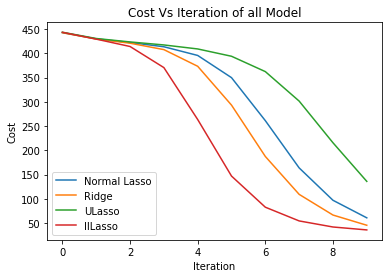

In [37]:
#Visualization of Cost vs Iteration of All the Model

Label=['Normal Lasso' ,'Ridge','ULasso','IILasso']
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Cost Vs Iteration of all Model')
for i in range(4):
    plt.plot(Iter[i],Cost[i],label=Label[i])
    plt.legend()
plt.show()

In [31]:
print(Cost[0][5],Cost[1][5],Cost[2][5],Cost[3][5])

120.62595393975204 123.46495692552088 167.3428476292736 90.78852969851116
